# Mutimobidity prediction

## 1. Basic Data Understanding
### a) Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### b) Loading Multimobidity Dataset

In [2]:
df = pd.read_csv("synthetic_multimorbidity_dataset FOR training the models.csv")
df.head()

,Age,Gender,Polyuria,Weight_loss,Weakness,Polyphagia,Genital_thrush,Visual_blurring,Itching,Irritability,Delayed_healing,Partial_paresis,Muscle_stiffness,Alopecia,Obesity,Multimorbidity
0,71,Male,0,0,1,0,0,1,0,1,0,0,0,0,0,1
1,34,Female,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,80,Male,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,40,Male,1,0,0,1,0,1,0,1,0,0,1,0,0,0
4,43,Male,0,1,0,1,0,1,1,0,0,1,0,0,0,0


#### b) Check column info to confirm column types and missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Gender            1000 non-null   object
 2   Polyuria          1000 non-null   int64 
 3   Weight_loss       1000 non-null   int64 
 4   Weakness          1000 non-null   int64 
 5   Polyphagia        1000 non-null   int64 
 6   Genital_thrush    1000 non-null   int64 
 7   Visual_blurring   1000 non-null   int64 
 8   Itching           1000 non-null   int64 
 9   Irritability      1000 non-null   int64 
 10  Delayed_healing   1000 non-null   int64 
 11  Partial_paresis   1000 non-null   int64 
 12  Muscle_stiffness  1000 non-null   int64 
 13  Alopecia          1000 non-null   int64 
 14  Obesity           1000 non-null   int64 
 15  Multimorbidity    1000 non-null   int64 
dtypes: int64(15), object(1)
memory usage: 125.1+ KB


## Exploratory Data Analysis

### 1. Check Target Distribution & Visualize
#### a) Countplot (absolute counts)

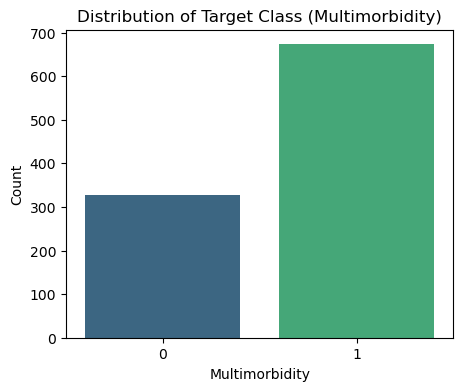

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x='Multimorbidity', hue= "Multimorbidity", 
              legend= False, data=df, palette='viridis')
plt.title('Distribution of Target Class (Multimorbidity)')
plt.xlabel('Multimorbidity')
plt.ylabel('Count')
plt.show()


#### b) Pie chart (proportions)

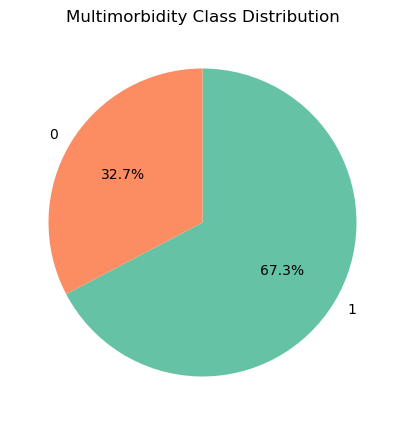

In [5]:
plt.figure(figsize=(5,5))
df['Multimorbidity'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, counterclock=False, colors=['#66c2a5','#fc8d62']
)
plt.ylabel('')
plt.title('Multimorbidity Class Distribution')
plt.show()


From the two plots, it is clear that the dataset is imbalanced:

- Class 0 (no multimorbidity) ~ 330 cases ~ 32.7%

- Class 1 (with multimorbidity) ~ 670 cases ~ 67.3%

Using accuracy can therefore be misleading since a model that always predicts “1” would get ~67% accuracy but would be useless for detecting “0”.

The best metrics to use for performance evaluation would be ROC_AUC, F1 score and Confusion Matrix.

### 2. Age vs. Multimorbidity

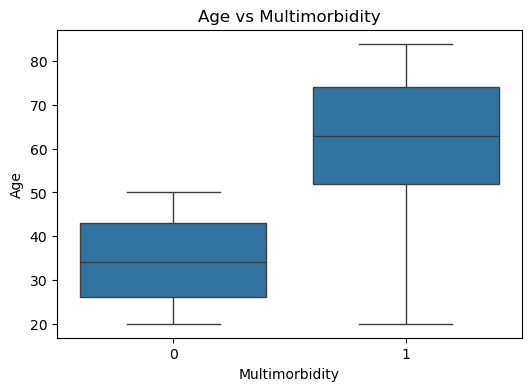

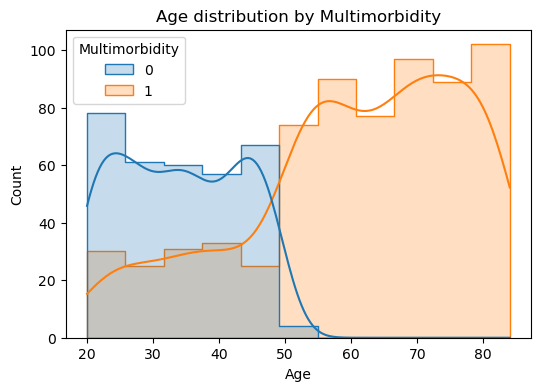

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x='Multimorbidity', y='Age', data=df)
plt.title('Age vs Multimorbidity')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Age', hue='Multimorbidity', kde=True, element='step')
plt.title('Age distribution by Multimorbidity')
plt.show()


#### From the observation:

1. Class 0 (No Multimorbidity – blue curve)

  - - These individuals are mostly younger.

 - - The density is higher between 20–45 years.

 - - Very few individuals above ~50 fall into the “No multimorbidity” group.

2. Class 1 (With Multimorbidity – orange curve)

- - This group dominates in the older ages.

- - Starts becoming common from ~50 years onward, and peaks around 60–80 years.

- - Very few younger people fall in this group.

3. Relationship between Age and Multimorbidity

- - Clear positive relationship: the probability of multimorbidity increases with age.

- - Younger individuals are more likely to be in class 0, while older individuals are much more likely to be in class 1.

- - Age seems to be a strong predictive feature for multimorbidity.

### 3. Gender vs. Multimorbidity

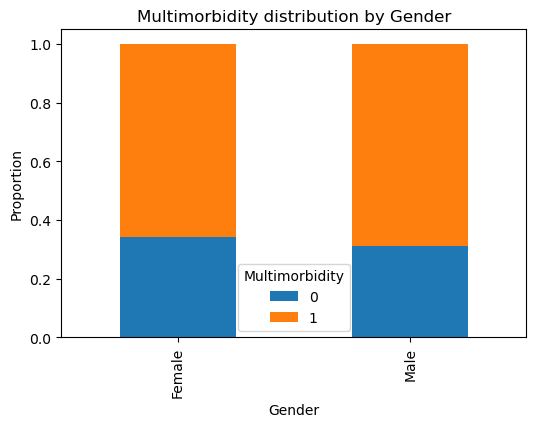

In [ ]:
pd.crosstab(df['Gender'], df['Multimorbidity'], normalize='index').plot(
    kind='bar', stacked=True, figsize=(6,4)
)
plt.title('Multimorbidity distribution by Gender')
plt.ylabel('Proportion')
plt.show()

From the observation, Male and Female groups show almost the same proportion of multimorbidity. This means gender is not strongly associated with multimorbidity.

### 4. Binary symptoms vs. Multimorbidity

#### a) Comparison

In [9]:
binary_cols = [c for c in df.columns if c not in ['Age','Gender','Multimorbidity']]

# calculate mean symptom rate grouped by target
symptom_comparison = df.groupby('Multimorbidity')[binary_cols].mean().T
symptom_comparison.columns = ['No Multimorbidity','With Multimorbidity']
symptom_comparison['Difference'] = (
    symptom_comparison['With Multimorbidity'] - symptom_comparison['No Multimorbidity']
)
print(symptom_comparison.sort_values('Difference', ascending=False).head(10))


                  No Multimorbidity  With Multimorbidity  Difference
Visual_blurring            0.220183             0.426449    0.206265
Weakness                   0.385321             0.546805    0.161484
Weight_loss                0.232416             0.369985    0.137569
Polyuria                   0.314985             0.427935    0.112950
Obesity                    0.195719             0.274889    0.079170
Delayed_healing            0.174312             0.209510    0.035198
Genital_thrush             0.137615             0.163447    0.025833
Muscle_stiffness           0.204893             0.222883    0.017990
Itching                    0.256881             0.270431    0.013550
Polyphagia                 0.290520             0.303120    0.012600


#### b) Visualization

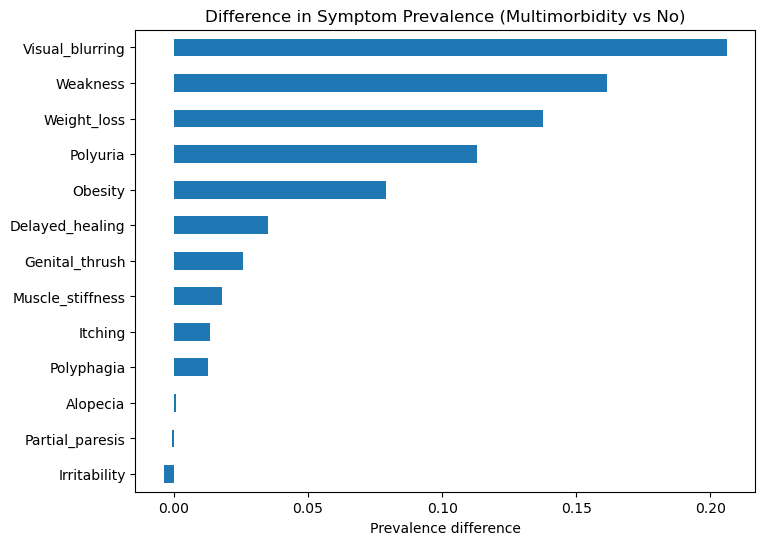

In [ ]:
plt.figure(figsize=(8,6))
symptom_comparison.sort_values('Difference', ascending=True)['Difference'].plot(kind='barh')
plt.title('Difference in Symptom Prevalence (Multimorbidity vs No)')
plt.xlabel('Prevalence difference')
plt.show()

From the observation:

- Longer bars = stronger association with multimorbidity.

- Top symptoms (Visual_blurring, Weakness, Weight_loss, Polyuria, Obesity) clearly stand out.

### 5. correlation HeatMap

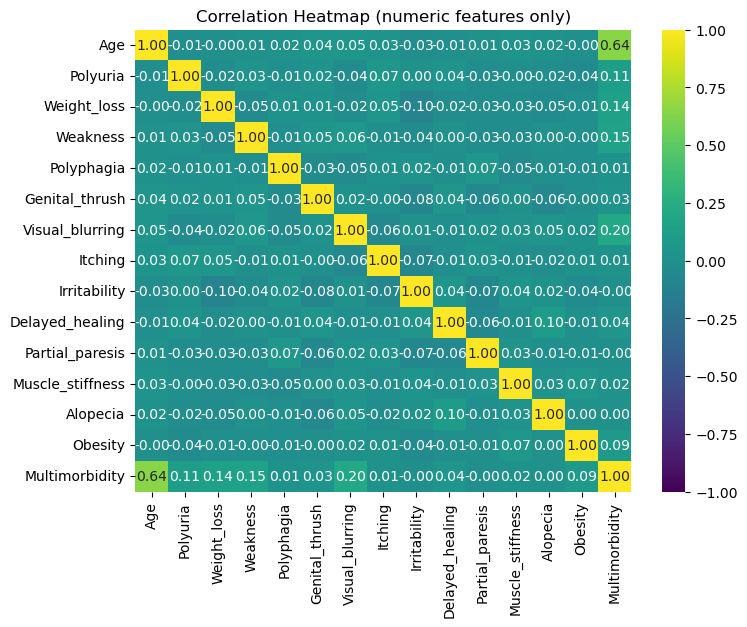

In [26]:
# drop non-numeric columns
corr = df.drop(columns=['Gender']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (numeric features only)')
plt.show()


## B. PREPROCESSING AND MODELLING

#### a) Preprocessing and modelling pipeline

This pipeline:

- One-hot encodes Gender.

- Standard scales numeric features (Age and the binary features — scaling is fine).

- Trains and evaluates Logistic Regression and RandomForest.

- Uses stratified train/test split and cross-validation scoring by ROC AUC.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split
X = df.drop(columns=['Multimorbidity'])
y = df['Multimorbidity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Column groups
categorical_cols = ['Gender']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# 3. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

# 4. pipelines
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 5. Quick baseline cross-val scores (roc_auc)
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("LR CV AUC:", np.mean(cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='roc_auc')))
print("RF CV AUC:", np.mean(cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='roc_auc')))

LR CV AUC: 0.9444635977214005
RF CV AUC: 0.9987713675213676


The Random forest performs better at 99.88% compaired to the logistic regression at 94.44%

#### b) Testing performance using Different metrices


--- Logistic Regression ---
Accuracy : 0.855
Precision: 0.863013698630137
Recall   : 0.9333333333333333
F1-score : 0.896797153024911
ROC-AUC  : 0.9252421652421652

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.76        65
           1       0.86      0.93      0.90       135

    accuracy                           0.85       200
   macro avg       0.85      0.81      0.83       200
weighted avg       0.85      0.85      0.85       200



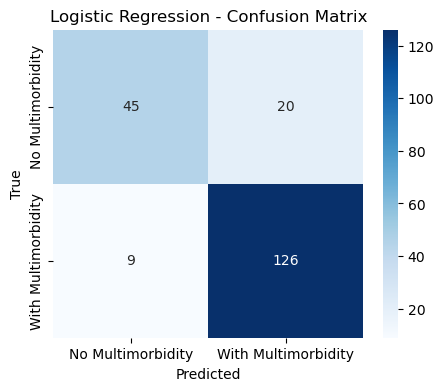

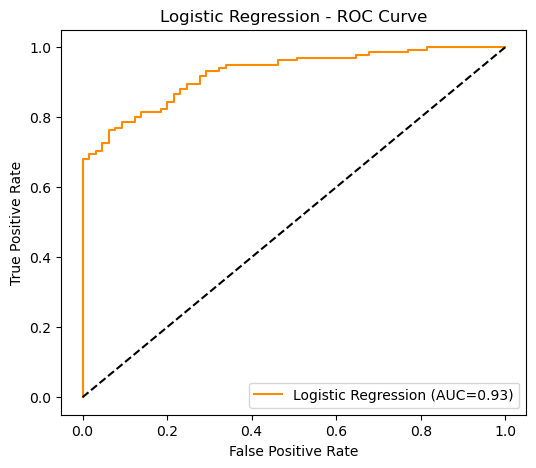


--- Random Forest ---
Accuracy : 0.995
Precision: 0.9926470588235294
Recall   : 1.0
F1-score : 0.996309963099631
ROC-AUC  : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.99      1.00      1.00       135

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



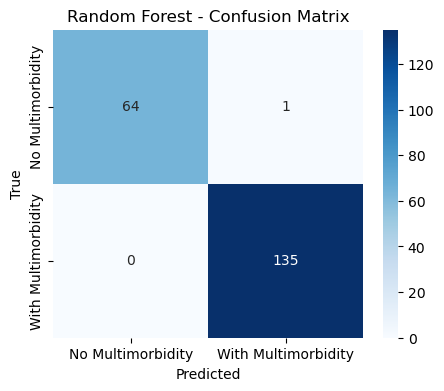

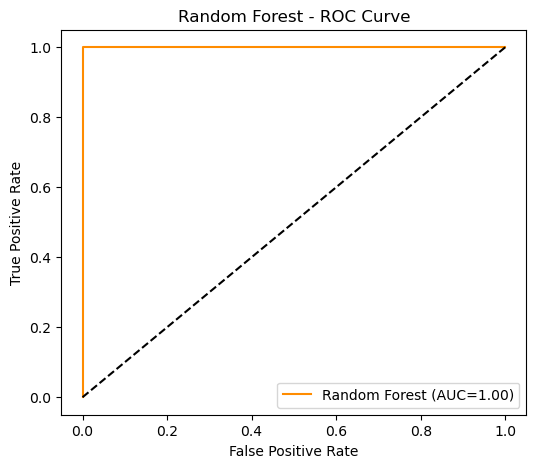

In [ ]:
# Fit models
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predictions
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_model(y_test, y_pred, y_proba, model_name):
    print(f"\n--- {model_name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Multimorbidity', 'With Multimorbidity'],
                yticklabels=['No Multimorbidity', 'With Multimorbidity'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', label=f'{model_name} (AUC={roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.show()

# Run evaluations
evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")


#### c) Model Performance Comparison

                     Accuracy  Precision    Recall  F1-score   ROC-AUC
Model                                                                 
Logistic Regression     0.855   0.863014  0.933333  0.896797  0.925242
Random Forest           0.995   0.992647  1.000000  0.996310  1.000000


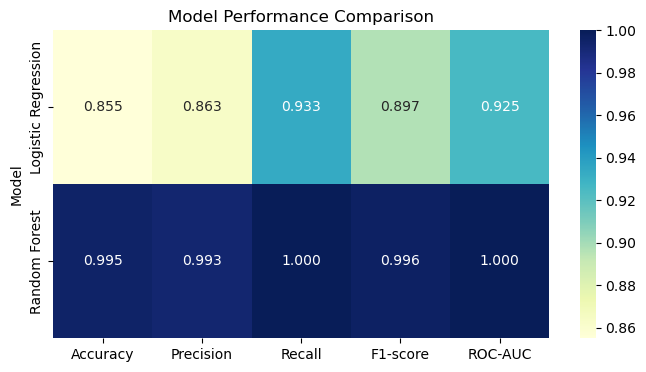

In [35]:
# Fit models
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predictions
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]


# Collect metrics
def get_metrics(y_test, y_pred, y_proba, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

metrics = []
metrics.append(get_metrics(y_test, y_pred_lr, y_proba_lr, "Logistic Regression"))
metrics.append(get_metrics(y_test, y_pred_rf, y_proba_rf, "Random Forest"))

results_df = pd.DataFrame(metrics).set_index("Model")
print(results_df)

# Plot heatmap of metrics for quick comparison
plt.figure(figsize=(8,4))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Model Performance Comparison")
plt.show()
